In [1]:
# %pip install lightgbm
# %pip install ipywidgets

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.ndimage import gaussian_filter

### 데이터 레이블링 (Labeling)

In [3]:
file_name = "total_thermal_noAC.csv"
df= pd.read_csv(file_name, dtype={69: str})

In [4]:
df

,True,timestamp,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,...,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,etc_1,etc_2,staus
0,0,2025-07-29 14:29:00,29.9375,25.75,25.25,25.25,25.75,25.75,24.50,24.75,...,50.75,42.50,25.25,24.75,25.75,23.25,22.50,242.0,226.0,heater
1,1,2025-07-29 14:29:00,29.9375,25.00,24.75,24.75,25.50,25.00,25.00,24.75,...,51.00,42.50,24.50,26.00,25.00,23.00,22.50,242.0,225.0,heater
2,2,2025-07-29 14:29:00,29.9375,25.25,25.25,25.50,25.75,25.75,25.50,25.75,...,51.25,42.75,25.00,25.75,25.00,23.00,22.25,241.0,225.0,heater
3,3,2025-07-29 14:29:01,30.0000,26.00,25.75,25.25,26.00,25.50,25.25,25.75,...,50.75,42.50,25.00,25.75,25.25,23.25,22.75,242.0,225.0,heater
4,4,2025-07-29 14:29:01,29.9375,26.25,25.75,25.50,26.00,25.00,25.50,25.75,...,50.25,42.75,25.25,26.00,25.50,23.00,22.25,242.0,225.0,heater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9997,2025-07-29 15:02:10,30.0625,24.25,24.50,25.25,25.25,25.00,24.75,24.25,...,23.25,24.50,24.25,24.75,24.50,23.50,22.50,241.0,225.0,NaN
9998,9998,2025-07-29 15:02:10,30.0625,24.25,23.75,25.25,24.75,25.00,24.25,24.00,...,24.25,24.00,24.25,23.75,24.50,22.25,23.00,241.0,225.0,NaN
9999,9999,2025-07-29 15:02:10,30.0625,24.75,25.00,24.50,25.00,24.75,24.25,23.75,...,24.25,24.25,24.25,23.75,24.75,22.75,22.75,241.0,225.0,NaN
10000,10000,2025-07-29 15:02:11,30.0625,24.25,24.50,24.50,24.75,24.00,25.00,23.25,...,24.00,24.50,24.00,24.00,24.25,22.50,21.75,241.0,225.0,NaN


In [5]:
df = df.drop(columns=['True','etc_1', 'etc_2'], errors='ignore')
df = df.reset_index(drop=True)

In [6]:
df

,timestamp,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,thermal_07,...,thermal_55,thermal_56,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,staus
0,2025-07-29 14:29:00,29.9375,25.75,25.25,25.25,25.75,25.75,24.50,24.75,24.75,...,23.50,24.50,50.75,42.50,25.25,24.75,25.75,23.25,22.50,heater
1,2025-07-29 14:29:00,29.9375,25.00,24.75,24.75,25.50,25.00,25.00,24.75,26.25,...,23.50,25.25,51.00,42.50,24.50,26.00,25.00,23.00,22.50,heater
2,2025-07-29 14:29:00,29.9375,25.25,25.25,25.50,25.75,25.75,25.50,25.75,26.25,...,23.25,24.75,51.25,42.75,25.00,25.75,25.00,23.00,22.25,heater
3,2025-07-29 14:29:01,30.0000,26.00,25.75,25.25,26.00,25.50,25.25,25.75,25.50,...,23.75,24.75,50.75,42.50,25.00,25.75,25.25,23.25,22.75,heater
4,2025-07-29 14:29:01,29.9375,26.25,25.75,25.50,26.00,25.00,25.50,25.75,26.00,...,23.50,24.75,50.25,42.75,25.25,26.00,25.50,23.00,22.25,heater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,2025-07-29 15:02:10,30.0625,24.25,24.50,25.25,25.25,25.00,24.75,24.25,24.75,...,23.50,24.25,23.25,24.50,24.25,24.75,24.50,23.50,22.50,NaN
9998,2025-07-29 15:02:10,30.0625,24.25,23.75,25.25,24.75,25.00,24.25,24.00,25.00,...,22.50,24.00,24.25,24.00,24.25,23.75,24.50,22.25,23.00,NaN
9999,2025-07-29 15:02:10,30.0625,24.75,25.00,24.50,25.00,24.75,24.25,23.75,24.75,...,22.75,24.00,24.25,24.25,24.25,23.75,24.75,22.75,22.75,NaN
10000,2025-07-29 15:02:11,30.0625,24.25,24.50,24.50,24.75,24.00,25.00,23.25,24.00,...,23.50,24.25,24.00,24.50,24.00,24.00,24.25,22.50,21.75,NaN


In [7]:
df['label'] = df['staus'].map({'NaN': 0, 'human1': 1, 'human2': 1})

In [8]:
df['label'] = df['label'].fillna(0)

In [9]:
print("매핑 후 발생한 결측치 개수:", df['label'].isnull().sum())

매핑 후 발생한 결측치 개수: 0


In [10]:
df = df.drop(columns=['staus'])

In [11]:
df.describe()

,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,thermal_07,thermal_08,...,thermal_55,thermal_56,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,label
count,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,...,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.00000
mean,30.082702,24.906344,24.919141,24.914817,25.236928,25.007449,26.014397,24.471431,25.282668,25.490777,...,24.621201,25.374725,25.395946,25.470431,26.056739,25.565762,26.041917,24.441762,24.147296,0.40222
std,0.172926,0.716271,0.653509,0.614526,0.631789,0.762716,8.011634,1.090485,0.789162,0.669301,...,3.911741,0.799212,3.360931,1.114314,5.831315,1.520559,3.457191,2.966682,0.993199,0.49037
min,29.750000,22.750000,22.750000,22.750000,23.250000,23.000000,22.750000,21.750000,23.000000,23.500000,...,21.250000,22.000000,22.500000,23.000000,23.250000,23.000000,23.000000,21.500000,20.500000,0.00000
25%,30.000000,24.500000,24.500000,24.500000,24.750000,24.500000,24.250000,24.000000,24.750000,25.000000,...,23.750000,24.750000,24.750000,25.000000,25.000000,25.000000,25.250000,23.500000,23.500000,0.00000
50%,30.062500,24.750000,24.750000,24.750000,25.250000,25.000000,24.750000,24.250000,25.250000,25.500000,...,24.000000,25.250000,25.000000,25.500000,25.250000,25.500000,25.500000,24.000000,24.000000,0.00000
75%,30.125000,25.250000,25.250000,25.250000,25.500000,25.250000,25.250000,24.750000,25.750000,25.750000,...,24.500000,25.750000,25.500000,25.750000,25.750000,25.750000,26.000000,24.500000,24.750000,1.00000
max,30.687500,27.750000,27.750000,29.500000,28.750000,47.250000,88.250000,50.250000,29.000000,31.250000,...,63.000000,29.750000,71.000000,43.250000,78.250000,38.750000,53.500000,60.250000,30.250000,1.00000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      10002 non-null  object 
 1   sensor_degree  10002 non-null  float64
 2   thermal_00     10002 non-null  float64
 3   thermal_01     10002 non-null  float64
 4   thermal_02     10002 non-null  float64
 5   thermal_03     10002 non-null  float64
 6   thermal_04     10002 non-null  float64
 7   thermal_05     10002 non-null  float64
 8   thermal_06     10002 non-null  float64
 9   thermal_07     10002 non-null  float64
 10  thermal_08     10002 non-null  float64
 11  thermal_09     10002 non-null  float64
 12  thermal_10     10002 non-null  float64
 13  thermal_11     10002 non-null  float64
 14  thermal_12     10002 non-null  float64
 15  thermal_13     10002 non-null  float64
 16  thermal_14     10002 non-null  float64
 17  thermal_15     10002 non-null  float64
 18  therma

In [13]:
df

,timestamp,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,thermal_07,...,thermal_55,thermal_56,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,label
0,2025-07-29 14:29:00,29.9375,25.75,25.25,25.25,25.75,25.75,24.50,24.75,24.75,...,23.50,24.50,50.75,42.50,25.25,24.75,25.75,23.25,22.50,0.0
1,2025-07-29 14:29:00,29.9375,25.00,24.75,24.75,25.50,25.00,25.00,24.75,26.25,...,23.50,25.25,51.00,42.50,24.50,26.00,25.00,23.00,22.50,0.0
2,2025-07-29 14:29:00,29.9375,25.25,25.25,25.50,25.75,25.75,25.50,25.75,26.25,...,23.25,24.75,51.25,42.75,25.00,25.75,25.00,23.00,22.25,0.0
3,2025-07-29 14:29:01,30.0000,26.00,25.75,25.25,26.00,25.50,25.25,25.75,25.50,...,23.75,24.75,50.75,42.50,25.00,25.75,25.25,23.25,22.75,0.0
4,2025-07-29 14:29:01,29.9375,26.25,25.75,25.50,26.00,25.00,25.50,25.75,26.00,...,23.50,24.75,50.25,42.75,25.25,26.00,25.50,23.00,22.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,2025-07-29 15:02:10,30.0625,24.25,24.50,25.25,25.25,25.00,24.75,24.25,24.75,...,23.50,24.25,23.25,24.50,24.25,24.75,24.50,23.50,22.50,0.0
9998,2025-07-29 15:02:10,30.0625,24.25,23.75,25.25,24.75,25.00,24.25,24.00,25.00,...,22.50,24.00,24.25,24.00,24.25,23.75,24.50,22.25,23.00,0.0
9999,2025-07-29 15:02:10,30.0625,24.75,25.00,24.50,25.00,24.75,24.25,23.75,24.75,...,22.75,24.00,24.25,24.25,24.25,23.75,24.75,22.75,22.75,0.0
10000,2025-07-29 15:02:11,30.0625,24.25,24.50,24.50,24.75,24.00,25.00,23.25,24.00,...,23.50,24.25,24.00,24.50,24.00,24.00,24.25,22.50,21.75,0.0


### 데이터 시각화

In [14]:
# --- 전처리 파라미터 설정 ---
NEW_SIZE = (24, 24)
GAUSSIAN_SIGMA = 0.7

In [15]:
# --- 데이터 전처리 실행 ---
thermal_columns = [f'thermal_{i:02d}' for i in range(64)]
processed_images = []

In [16]:
# tqdm을 사용해 진행률 표시
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # 1. 8x8 그리드로 변환
    thermal_values = row[thermal_columns].values.astype(np.float32)
    original_grid = thermal_values.reshape(8, 8)
    
    # 2. 24x24로 업샘플링 (3차 보간법)
    upscaled_grid = cv2.resize(original_grid, NEW_SIZE, interpolation=cv2.INTER_CUBIC)
    
    # 3. 가우시안 필터 적용
    final_grid = gaussian_filter(upscaled_grid, sigma=GAUSSIAN_SIGMA)
    
    # 4. 처리된 이미지를 리스트에 추가
    processed_images.append(final_grid)

# 리스트를 NumPy 배열로 변환
X = np.array(processed_images)
y = df['label'].values

print("\n--- 전처리 완료! ---")
print(f"최종 입력 데이터(X) 형태: {X.shape}")
print(f"최종 라벨 데이터(y) 형태: {y.shape}")

  0%|          | 0/10002 [00:00<?, ?it/s]


--- 전처리 완료! ---
최종 입력 데이터(X) 형태: (10002, 24, 24)
최종 라벨 데이터(y) 형태: (10002,)


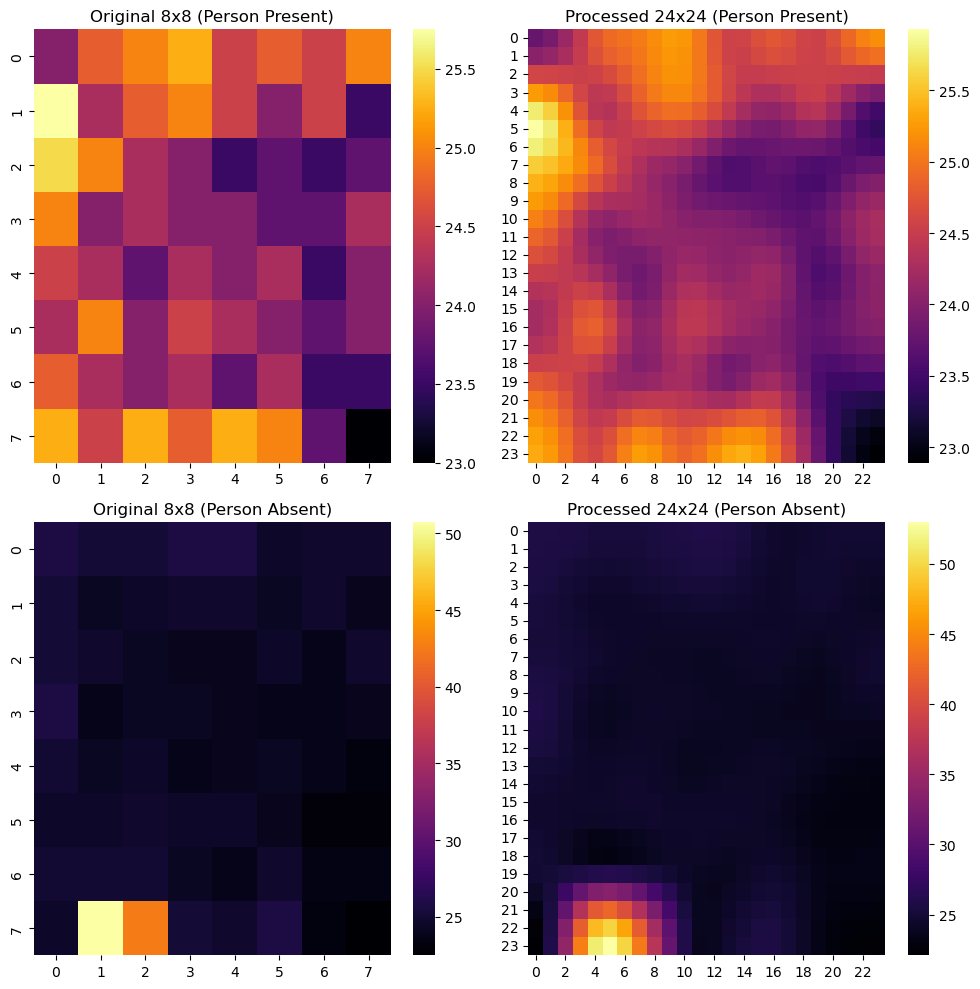

In [17]:
# --- 결과 시각화로 확인 ---
# 사람이 있는 샘플과 없는 샘플 하나씩 비교
sample_idx_present = np.where(y == 1)[0][0]
sample_idx_absent = np.where(y == 0)[0][0]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 사람이 있는 경우
original_present = df.loc[sample_idx_present, thermal_columns].values.astype(float).reshape(8, 8)
axes[0, 0].set_title('Original 8x8 (Person Present)')
sns.heatmap(original_present, ax=axes[0, 0], cmap='inferno', annot=False)
axes[0, 1].set_title('Processed 24x24 (Person Present)')
sns.heatmap(X[sample_idx_present], ax=axes[0, 1], cmap='inferno', annot=False)

# 사람이 없는 경우
original_absent = df.loc[sample_idx_absent, thermal_columns].values.astype(float).reshape(8, 8)
axes[1, 0].set_title('Original 8x8 (Person Absent)')
sns.heatmap(original_absent, ax=axes[1, 0], cmap='inferno', annot=False)
axes[1, 1].set_title('Processed 24x24 (Person Absent)')
sns.heatmap(X[sample_idx_absent], ax=axes[1, 1], cmap='inferno', annot=False)

plt.tight_layout()
plt.show()

### 온도 분포 기반
1. 전반적인 온도 특성:
    1-1. mean_temp: 64픽셀의 평균 온도
    1-2. std_temp: 64픽셀의 표준편차. (가장 중요할 것으로 예상) 사람이 있으면 
                   뜨거운 부분과 차가운 부분이 공존하므로 온도 변화가 커져 이 값이 높아집니다.
    1-3. max_temp, min_temp: 최고/최저 온도
2. 온도 분포의 형태 특성:
    2-1. q95_temp, q75_temp: 상위 5%, 25% 지점의 온도. max_temp보다 노이즈에 강건합니다.
    2-2. max_minus_mean: 최고 온도 - 평균 온도. 뜨거운 부분이 얼마나 '튀는지' 나타냅니다.

In [18]:
# --- 1. [완전 수정] 단순 통계 특성 추출 ---
all_features = []
# 라벨을 제외한 순수 온도 데이터 컬럼만 선택
thermal_columns = [col for col in df.columns if 'thermal' in str(col)]
data_to_process = df[thermal_columns]

print("--- 단순 통계 특성 추출 시작 ---")
for i in tqdm(range(len(data_to_process))):
    # 각 행(샘플)의 온도 데이터
    temps = data_to_process.iloc[i].values
    
    features = {}
    
    # 기본 통계 특성
    features['mean_temp'] = np.mean(temps)
    features['std_temp'] = np.std(temps)
    features['max_temp'] = np.max(temps)
    features['min_temp'] = np.min(temps)
    
    # 분포 관련 특성
    features['q95_temp'] = np.quantile(temps, 0.95) # 상위 5% 온도
    features['q75_temp'] = np.quantile(temps, 0.75) # 상위 25% 온도
    
    # 대비(Contrast) 특성
    features['max_minus_mean'] = features['max_temp'] - features['mean_temp']
    
    all_features.append(features)

# 새로운 특성 데이터프레임 생성
X = pd.DataFrame(all_features)
y = df['label'].astype(int).values

print("\n--- 특성 추출 완료 ---")
print("새롭게 생성된 특성 데이터프레임 (X) 샘플:")
print(X.head())
print(f"\n데이터 형태: {X.shape}")
print("-" * 30)


--- 단순 통계 특성 추출 시작 ---


  0%|          | 0/10002 [00:00<?, ?it/s]


--- 특성 추출 완료 ---
새롭게 생성된 특성 데이터프레임 (X) 샘플:
   mean_temp  std_temp  max_temp  min_temp  q95_temp  q75_temp  max_minus_mean
0  25.101562  3.996023     50.75     22.50   25.7500   24.8125       25.648438
1  25.222656  3.992453     51.00     22.50   25.9250   25.0000       25.777344
2  25.460938  3.999809     51.25     22.25   25.7500   25.2500       25.789062
3  25.457031  3.925218     50.75     22.75   25.9625   25.2500       25.292969
4  25.535156  3.890309     50.25     22.25   26.0000   25.5000       24.714844

데이터 형태: (10002, 7)
------------------------------


In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

--- 랜덤 포레스트 모델 학습 시작 ---
--- 모델 학습 완료 ---

--- 모델 성능 평가 ---
정확도: 0.8251

분류 리포트:
              precision    recall  f1-score   support

   Empty (0)       0.84      0.88      0.86      1196
  Person (1)       0.80      0.75      0.78       805

    accuracy                           0.83      2001
   macro avg       0.82      0.81      0.82      2001
weighted avg       0.82      0.83      0.82      2001



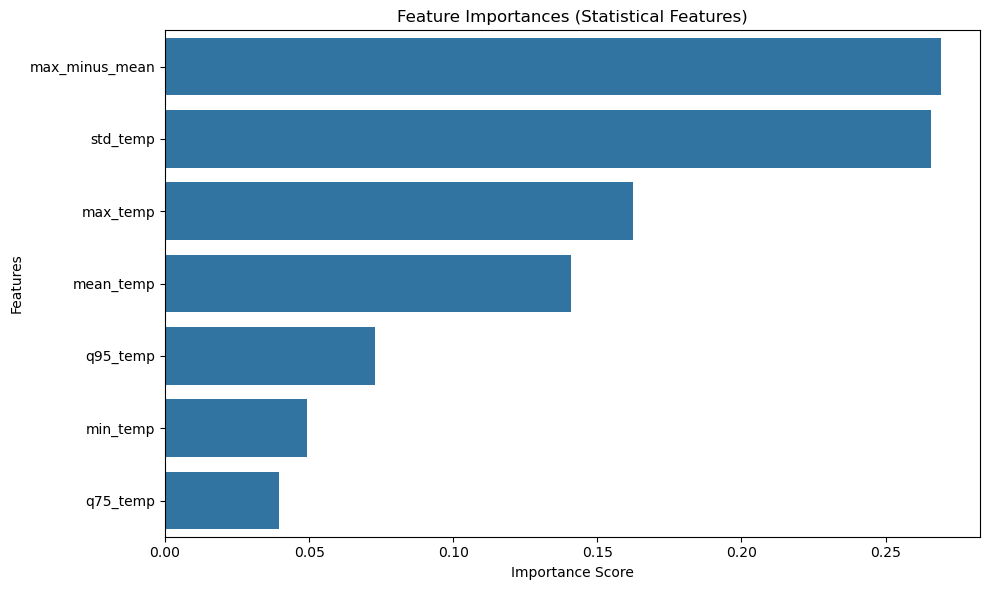

In [20]:
# --- 2. 머신러닝 모델 학습 및 평가 (변경 없음) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("--- 랜덤 포레스트 모델 학습 시작 ---")
model.fit(X_train, y_train)
print("--- 모델 학습 완료 ---\n")

y_pred = model.predict(X_test)
print("--- 모델 성능 평가 ---")
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, target_names=['Empty (0)', 'Person (1)']))

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances (Statistical Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

--- LightGBM 모델 학습 시작 ---
[LightGBM] [Info] Number of positive: 3218, number of negative: 4783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 8001, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402200 -> initscore=-0.396308
[LightGBM] [Info] Start training from score -0.396308
--- 모델 학습 완료 ---

--- LightGBM 모델 성능 평가 ---
정확도: 0.8406

분류 리포트:
              precision    recall  f1-score   support

   Empty (0)       0.85      0.89      0.87      1196
  Person (1)       0.82      0.77      0.79       805

    accuracy                           0.84      2001
   macro avg       0.84      0.83      0.83      2001
weighted avg       0.84      0.84      0.84      2001



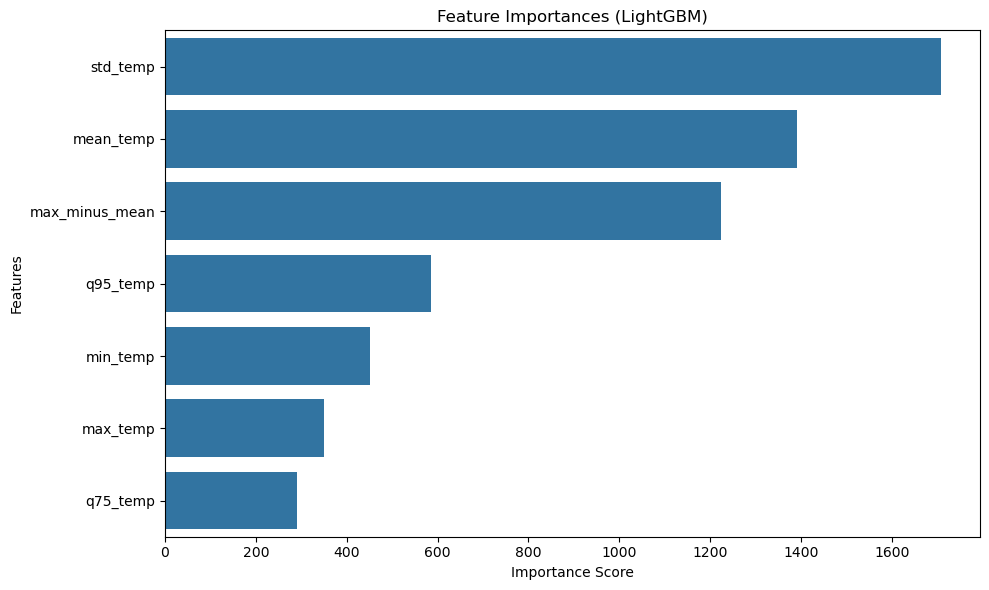

In [21]:
# --- 2. [수정] LightGBM 모델 학습 및 평가 ---
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 데이터를 학습용과 테스트용으로 분리 (이전과 동일)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBM 모델 생성 및 학습
# n_estimators: 부스팅 단계(나무)의 수
# learning_rate: 학습률
lgbm_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)

print("--- LightGBM 모델 학습 시작 ---")
lgbm_model.fit(X_train, y_train)
print("--- 모델 학습 완료 ---\n")

# 예측 및 성능 평가
y_pred_lgbm = lgbm_model.predict(X_test)

print("--- LightGBM 모델 성능 평가 ---")
print(f"정확도: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("\n분류 리포트:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Empty (0)', 'Person (1)']))

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(lgbm_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances (LightGBM)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [22]:
# --- 0. 실제 데이터프레임 로드 ---
# df = pd.read_csv('내_데이터.csv')
# ... (이전과 동일하게 df를 로드했다고 가정)

# --- 1. [수정] 공간 정보를 포함한 특성 추출 ---
all_features = []
thermal_columns = [col for col in df.columns if 'thermal' in str(col)]
data_to_process = df[thermal_columns]

print("--- 공간 정보를 포함한 정교한 특성 추출 시작 ---")
for i in tqdm(range(len(data_to_process))):
    # 8x8 2D 배열로 변환
    frame_2d = data_to_process.iloc[i].values.reshape(8, 8)
    
    features = {}
    
    # --- 기존의 전역(Global) 통계 특성 ---
    features['mean_temp'] = np.mean(frame_2d)
    features['std_temp'] = np.std(frame_2d)
    features['max_temp'] = np.max(frame_2d)
    features['min_temp'] = np.min(frame_2d)
    features['q95_temp'] = np.quantile(frame_2d, 0.95)
    features['q75_temp'] = np.quantile(frame_2d, 0.75)
    features['max_minus_mean'] = features['max_temp'] - features['mean_temp']
    
    # --- [핵심 추가] 공간(Zonal) 특성 ---
    # 중앙 4x4 구역 정의
    center_zone = frame_2d[2:6, 2:6]
    
    features['center_mean_temp'] = np.mean(center_zone)
    features['center_max_temp'] = np.max(center_zone)
    features['center_std_temp'] = np.std(center_zone)
    
    # 중심-전체 대비 특성
    features['center_vs_global_mean_diff'] = features['center_mean_temp'] - features['mean_temp']
    features['center_vs_global_max_diff'] = features['center_max_temp'] - features['max_temp']
    
    # [추가] 최대 온도의 위치 정보
    max_pos = np.unravel_index(np.argmax(frame_2d), frame_2d.shape)
    features['max_temp_y_pos'] = max_pos[0]
    features['max_temp_x_pos'] = max_pos[1]
    
    all_features.append(features)

# 새로운 특성 데이터프레임 생성
X = pd.DataFrame(all_features)
y = df['label'].astype(int).values

print("\n--- 특성 추출 완료 ---")
print("새롭게 생성된 특성 데이터프레임 (X) 샘플:")
print(X.head())
print(f"\n데이터 형태: {X.shape}")
print("-" * 30)


--- 공간 정보를 포함한 정교한 특성 추출 시작 ---


  0%|          | 0/10002 [00:00<?, ?it/s]


--- 특성 추출 완료 ---
새롭게 생성된 특성 데이터프레임 (X) 샘플:
   mean_temp  std_temp  max_temp  min_temp  q95_temp  q75_temp  \
0  25.101562  3.996023     50.75     22.50   25.7500   24.8125   
1  25.222656  3.992453     51.00     22.50   25.9250   25.0000   
2  25.460938  3.999809     51.25     22.25   25.7500   25.2500   
3  25.457031  3.925218     50.75     22.75   25.9625   25.2500   
4  25.535156  3.890309     50.25     22.25   26.0000   25.5000   

   max_minus_mean  center_mean_temp  center_max_temp  center_std_temp  \
0       25.648438         24.203125            24.75         0.282549   
1       25.777344         24.406250            25.25         0.352170   
2       25.789062         24.671875            25.50         0.339102   
3       25.292969         24.531250            25.00         0.291481   
4       24.714844         24.734375            25.00         0.257220   

   center_vs_global_mean_diff  center_vs_global_max_diff  max_temp_y_pos  \
0                   -0.898438               

In [23]:
# --- 테스트 결과 상세 시각화 (공간 특성 포함) ---

# 시각화를 위한 함수 정의
def visualize_spatial_prediction(idx, X_test_df, y_test_arr, y_pred_arr, original_data_df, thermal_cols_list):
    """
    공간 특성을 포함한 모델의 예측 결과를 시각화합니다.
    """
    # 선택된 테스트 샘플의 정보 가져오기
    true_label = y_test_arr[idx]
    predicted_label = y_pred_arr[idx]
    features_used = X_test_df.iloc[idx]
    
    # X_test의 인덱스를 사용하여 원본 df의 인덱스 찾기
    original_df_idx = X_test_df.index[idx]
    original_thermal_data = original_data_df.loc[original_df_idx, thermal_cols_list]

    # 시각화 레이아웃 설정
    fig = plt.figure(figsize=(16, 7))
    # GridSpec을 사용하여 레이아웃을 더 유연하게 만듦
    gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1])
    ax0 = fig.add_subplot(gs[0]) # 히트맵
    ax1 = fig.add_subplot(gs[1]) # 예측 결과 및 전역/대비 특성
    ax2 = fig.add_subplot(gs[2]) # 공간/위치 특성
    
    fig.suptitle(f"Prediction for Original Sample Index: {original_df_idx}", fontsize=16)

    # 1. 왼쪽: 원본 8x8 히트맵 + 중심부 표시
    heatmap_data = original_thermal_data.values.astype(float).reshape(8, 8)
    sns.heatmap(heatmap_data, ax=ax0, cmap='inferno', annot=True, fmt=".1f", linewidths=.5, cbar=True)
    ax0.set_title("Original 8x8 Thermal Image")
    # 중심 4x4 구역에 사각형 그리기
    ax0.add_patch(plt.Rectangle((2, 2), 4, 4, fill=False, edgecolor='cyan', lw=2))
    ax0.text(2, 1.8, 'Center Zone', color='cyan', fontsize=10)

    # 2. 중간: 예측 결과 및 기본 특성
    ax1.axis('off')
    true_text = "Person (1)" if true_label == 1 else "Empty (0)"
    pred_text = "Person (1)" if predicted_label == 1 else "Empty (0)"
    result_color = 'green' if true_label == predicted_label else 'red'
    ax1.text(0.0, 1.0, f"True Label: {true_text}", fontsize=14, weight='bold')
    ax1.text(0.0, 0.9, f"Model's Prediction: {pred_text}", fontsize=14, weight='bold', color=result_color)

    ax1.text(0.0, 0.75, "Global & Contrast Features:", fontsize=12, weight='bold')
    global_features_text = (
        f"- mean_temp: {features_used['mean_temp']:.2f}\n"
        f"- std_temp: {features_used['std_temp']:.2f}\n"
        f"- max_temp: {features_used['max_temp']:.2f}\n"
        f"- max_minus_mean: {features_used['max_minus_mean']:.2f}\n"
    )
    ax1.text(0.0, 0.45, global_features_text, fontsize=11)
    
    # 3. 오른쪽: 공간/위치 특성
    ax2.axis('off')
    ax2.text(0.0, 0.75, "Spatial & Positional Features:", fontsize=12, weight='bold')
    spatial_features_text = (
        f"- center_mean_temp: {features_used['center_mean_temp']:.2f}\n"
        f"- center_std_temp: {features_used['center_std_temp']:.2f}\n"
        f"- center_vs_global_mean_diff: {features_used['center_vs_global_mean_diff']:.2f}\n\n"
        f"- max_temp_y_pos: {features_used['max_temp_y_pos']:.0f}\n"
        f"- max_temp_x_pos: {features_used['max_temp_x_pos']:.0f}\n"
    )
    ax2.text(0.0, 0.1, spatial_features_text, fontsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [26]:
y_pred.shape

(2001,)


--- Case 1: Correctly Predicted as 'Person' (True Positive) ---


KeyError: 'center_mean_temp'

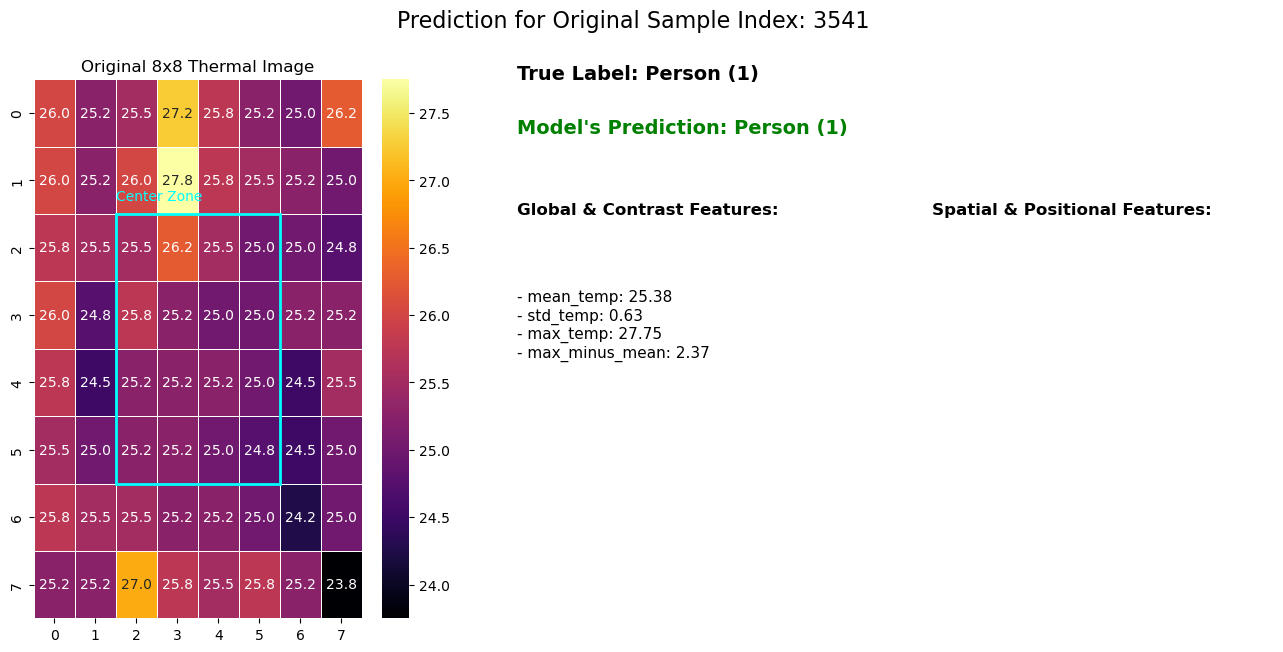

In [24]:
# --- 다양한 케이스의 예측 결과 확인 ---
# (이전과 동일한 로직)
tp_indices = np.where((y_test == 1) & (y_pred == 1))[0]
if len(tp_indices) > 0:
    print("\n--- Case 1: Correctly Predicted as 'Person' (True Positive) ---")
    visualize_spatial_prediction(tp_indices[0], X_test, y_test, y_pred, df, thermal_columns)

tn_indices = np.where((y_test == 0) & (y_pred == 0))[0]
if len(tn_indices) > 0:
    print("\n--- Case 2: Correctly Predicted as 'Empty' (True Negative) ---")
    visualize_spatial_prediction(tn_indices[0], X_test, y_test, y_pred, df, thermal_columns)
    
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
if len(fp_indices) > 0:
    print("\n--- Case 3: Incorrectly Predicted as 'Person' (False Positive) ---")
    visualize_spatial_prediction(fp_indices[0], X_test, y_test, y_pred, df, thermal_columns)

fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
if len(fn_indices) > 0:
    print("\n--- Case 4: Incorrectly Predicted as 'Empty' (False Negative) ---")
    visualize_spatial_prediction(fn_indices[0], X_test, y_test, y_pred, df, thermal_columns)

### 24x24 증강 + LightGBM 모델

In [27]:
# --- 0. 실제 데이터프레임 로드 ---
# df = pd.read_csv('내_데이터.csv')
# ... (이전과 동일하게 df를 로드했다고 가정)

# --- 1. [수정] 24x24 증강 이미지를 기반으로 특성 추출 ---
all_features = []
thermal_columns = [col for col in df.columns if 'thermal' in str(col)]
data_to_process_raw = df[thermal_columns].values # .values를 이용해 NumPy 배열로 바로 추출

# 전처리 파라미터
TARGET_SIZE = (24, 24)

print("--- 24x24 증강 및 특성 추출 시작 ---")
for i in tqdm(range(len(data_to_process_raw))):
    # 1-1. 8x8 -> 24x24 이미지 증강
    frame_8x8 = data_to_process_raw[i].reshape(8, 8)
    frame_24x24 = cv2.resize(frame_8x8, TARGET_SIZE, interpolation=cv2.INTER_CUBIC)
    
    # 이제 모든 특성을 24x24 이미지(frame_24x24)에서 계산합니다.
    features = {}
    
    # --- 전역(Global) 통계 특성 ---
    features['mean_temp'] = np.mean(frame_24x24)
    features['std_temp'] = np.std(frame_24x24)
    features['max_temp'] = np.max(frame_24x24)
    features['min_temp'] = np.min(frame_24x24)
    features['q95_temp'] = np.quantile(frame_24x24, 0.95)
    features['max_minus_mean'] = features['max_temp'] - features['mean_temp']
    
    # --- 공간(Zonal) 특성 (24x24 기준에 맞게 인덱스 조정) ---
    # 중앙 12x12 구역 정의 (24*0.25=6, 24*0.75=18)
    center_zone = frame_24x24[6:18, 6:18]
    
    features['center_mean_temp'] = np.mean(center_zone)
    features['center_std_temp'] = np.std(center_zone)
    features['center_vs_global_mean_diff'] = features['center_mean_temp'] - features['mean_temp']
    
    # 최대 온도의 위치 정보 (24x24 이미지 기준)
    max_pos = np.unravel_index(np.argmax(frame_24x24), frame_24x24.shape)
    features['max_temp_y_pos'] = max_pos[0]
    features['max_temp_x_pos'] = max_pos[1]
    
    all_features.append(features)

# 새로운 특성 데이터프레임 생성
X = pd.DataFrame(all_features)
y = df['label'].astype(int).values

print("\n--- 특성 추출 완료 ---")
print("새롭게 생성된 특성 데이터프레임 (X) 샘플:")
print(X.head())
print(f"\n데이터 형태: {X.shape}")
print("-" * 30)

--- 24x24 증강 및 특성 추출 시작 ---


  0%|          | 0/10002 [00:00<?, ?it/s]


--- 특성 추출 완료 ---
새롭게 생성된 특성 데이터프레임 (X) 샘플:
   mean_temp  std_temp   max_temp   min_temp   q95_temp  max_minus_mean  \
0  25.093462  3.826570  55.026236  21.203711  28.407798       29.932773   
1  25.215361  3.819994  55.196503  21.885565  27.934893       29.981142   
2  25.454221  3.828594  55.510804  21.453711  28.835570       30.056583   
3  25.450089  3.756607  54.984569  21.512353  28.661702       29.534481   
4  25.528873  3.729795  54.599796  21.638896  28.752323       29.070923   

   center_mean_temp  center_std_temp  center_vs_global_mean_diff  \
0         24.163431         0.239303                   -0.930031   
1         24.383039         0.352815                   -0.832322   
2         24.644192         0.298050                   -0.810029   
3         24.517008         0.288446                   -0.933080   
4         24.722737         0.280725                   -0.806135   

   max_temp_y_pos  max_temp_x_pos  
0              23               5  
1              23       

In [28]:
# --- 2. LightGBM 모델 학습 및 평가 (변경 없음) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lgbm_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)
print("--- LightGBM 모델 학습 시작 ---")
lgbm_model.fit(X_train, y_train)
print("--- 모델 학습 완료 ---\n")

y_pred = lgbm_model.predict(X_test)
print("--- 모델 성능 평가 ---")
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, target_names=['Empty (0)', 'Person (1)']))

--- LightGBM 모델 학습 시작 ---
[LightGBM] [Info] Number of positive: 3218, number of negative: 4783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 8001, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402200 -> initscore=-0.396308
[LightGBM] [Info] Start training from score -0.396308
--- 모델 학습 완료 ---

--- 모델 성능 평가 ---
정확도: 0.8841

분류 리포트:
              precision    recall  f1-score   support

   Empty (0)       0.87      0.94      0.91      1196
  Person (1)       0.90      0.80      0.85       805

    accuracy                           0.88      2001
   macro avg       0.89      0.87      0.88      2001
weighted avg       0.89      0.88      0.88      2001



In [29]:
# --- 3. [수정] 24x24 증강 이미지 기반의 테스트 결과 상세 시각화 ---

# 시각화를 위한 함수 정의
def visualize_spatial_prediction(idx, X_test_df, y_test_arr, y_pred_arr, original_data_df, thermal_cols_list):
    """
    24x24 증강 이미지를 기반으로 모델의 예측 결과를 시각화합니다.
    """
    # 선택된 테스트 샘플의 정보 가져오기
    true_label = y_test_arr[idx]
    predicted_label = y_pred_arr[idx]
    features_used = X_test_df.iloc[idx]
    
    # X_test의 인덱스를 사용하여 원본 df의 인덱스 찾기
    original_df_idx = X_test_df.index[idx]
    original_thermal_data_1d = original_data_df.loc[original_df_idx, thermal_cols_list].values
    
    # --- [핵심 수정] 시각화를 위해 24x24 이미지 다시 생성 ---
    TARGET_SIZE = (24, 24)
    frame_8x8 = original_thermal_data_1d.astype(float).reshape(8, 8)
    heatmap_data_24x24 = cv2.resize(frame_8x8, TARGET_SIZE, interpolation=cv2.INTER_CUBIC)

    # 시각화 레이아웃 설정
    fig = plt.figure(figsize=(16, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1])
    ax0 = fig.add_subplot(gs[0]) # 히트맵
    ax1 = fig.add_subplot(gs[1]) # 예측 결과 및 전역/대비 특성
    ax2 = fig.add_subplot(gs[2]) # 공간/위치 특성
    
    fig.suptitle(f"Prediction for Original Sample Index: {original_df_idx}", fontsize=16)

    # 1. 왼쪽: 24x24 증강 히트맵 + 중심부 표시
    sns.heatmap(heatmap_data_24x24, ax=ax0, cmap='inferno', annot=False, cbar=True)
    ax0.set_title("Upsampled 24x24 Thermal Image")
    # 중심 12x12 구역에 사각형 그리기
    ax0.add_patch(plt.Rectangle((6, 6), 12, 12, fill=False, edgecolor='cyan', lw=2))
    ax0.text(6, 5.5, 'Center Zone', color='cyan', fontsize=10)

    # 2. 중간: 예측 결과 및 기본 특성
    ax1.axis('off')
    true_text = "Person (1)" if true_label == 1 else "Empty (0)"
    pred_text = "Person (1)" if predicted_label == 1 else "Empty (0)"
    result_color = 'green' if true_label == predicted_label else 'red'
    ax1.text(0.0, 1.0, f"True Label: {true_text}", fontsize=14, weight='bold')
    ax1.text(0.0, 0.9, f"Model's Prediction: {pred_text}", fontsize=14, weight='bold', color=result_color)

    ax1.text(0.0, 0.75, "Global & Contrast Features:", fontsize=12, weight='bold')
    global_features_text = (
        f"- mean_temp: {features_used['mean_temp']:.2f}\n"
        f"- std_temp: {features_used['std_temp']:.2f}\n"
        f"- max_temp: {features_used['max_temp']:.2f}\n"
        f"- max_minus_mean: {features_used['max_minus_mean']:.2f}\n"
    )
    ax1.text(0.0, 0.45, global_features_text, fontsize=11)
    
    # 3. 오른쪽: 공간/위치 특성
    ax2.axis('off')
    ax2.text(0.0, 0.75, "Spatial & Positional Features:", fontsize=12, weight='bold')
    spatial_features_text = (
        f"- center_mean_temp: {features_used['center_mean_temp']:.2f}\n"
        f"- center_std_temp: {features_used['center_std_temp']:.2f}\n"
        f"- center_vs_global_mean_diff: {features_used['center_vs_global_mean_diff']:.2f}\n\n"
        f"- max_temp_y_pos: {features_used['max_temp_y_pos']:.0f}\n"
        f"- max_temp_x_pos: {features_used['max_temp_x_pos']:.0f}\n"
    )
    ax2.text(0.0, 0.1, spatial_features_text, fontsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--- Case 1: Correctly Predicted as 'Person' (True Positive) ---


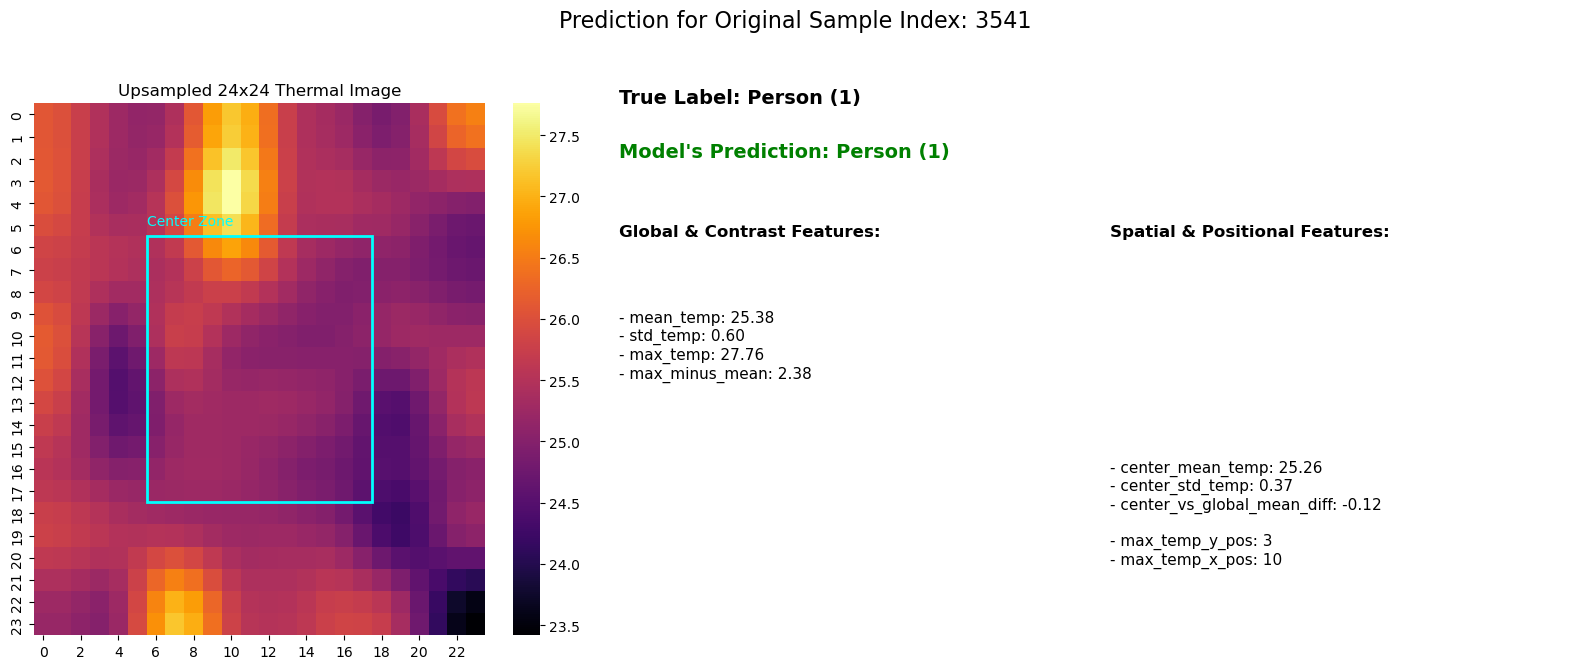


--- Case 2: Correctly Predicted as 'Empty' (True Negative) ---


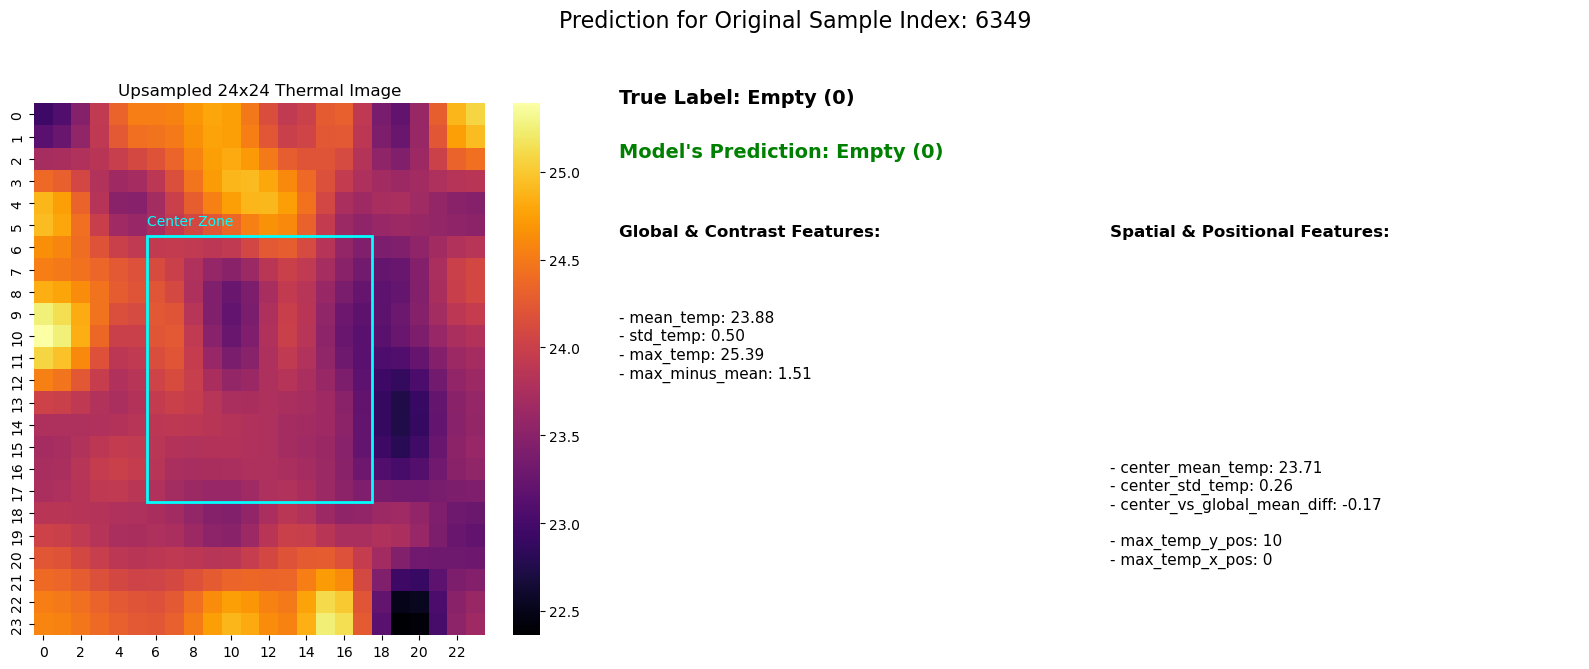


--- Case 3: Incorrectly Predicted as 'Person' (False Positive) ---


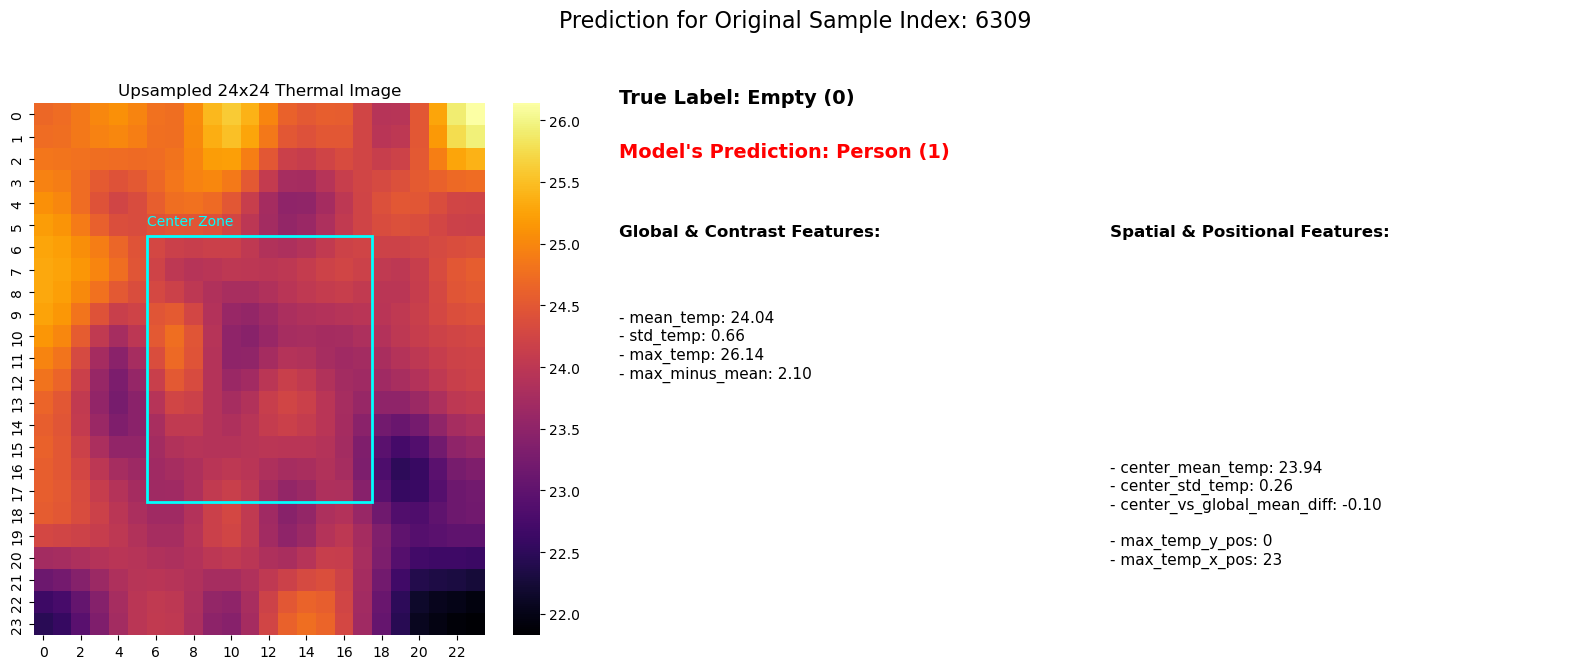


--- Case 4: Incorrectly Predicted as 'Empty' (False Negative) ---


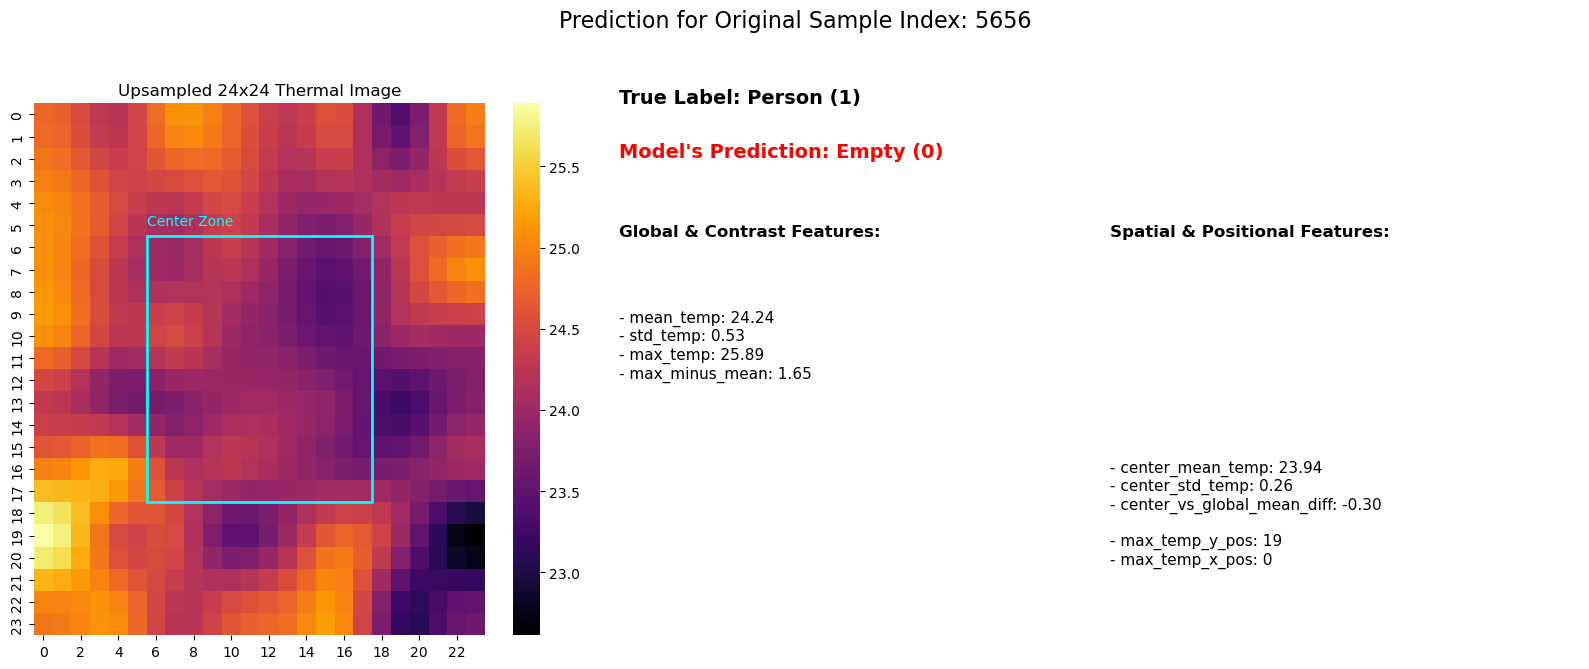

In [30]:
# --- 다양한 케이스의 예측 결과 확인 ---
# 이 부분은 이전과 동일하게 그대로 사용합니다.
tp_indices = np.where((y_test == 1) & (y_pred == 1))[0]
if len(tp_indices) > 0:
    print("\n--- Case 1: Correctly Predicted as 'Person' (True Positive) ---")
    visualize_spatial_prediction(tp_indices[0], X_test, y_test, y_pred, df, thermal_columns)

tn_indices = np.where((y_test == 0) & (y_pred == 0))[0]
if len(tn_indices) > 0:
    print("\n--- Case 2: Correctly Predicted as 'Empty' (True Negative) ---")
    visualize_spatial_prediction(tn_indices[0], X_test, y_test, y_pred, df, thermal_columns)
    
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
if len(fp_indices) > 0:
    print("\n--- Case 3: Incorrectly Predicted as 'Person' (False Positive) ---")
    visualize_spatial_prediction(fp_indices[0], X_test, y_test, y_pred, df, thermal_columns)

fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
if len(fn_indices) > 0:
    print("\n--- Case 4: Incorrectly Predicted as 'Empty' (False Negative) ---")
    visualize_spatial_prediction(fn_indices[0], X_test, y_test, y_pred, df, thermal_columns)

In [31]:
# 시각화를 위한 함수 정의
def visualize_with_bounding_box_thermo(idx, X_test_df, y_test_arr, y_pred_arr, original_data_df, thermal_cols_list):
    """
    온도 임계값을 기반으로 바운딩 박스를 그려 예측 결과를 시각화합니다.
    """
    # 기본 정보 가져오기
    true_label = y_test_arr[idx]
    predicted_label = y_pred_arr[idx]
    original_df_idx = X_test_df.index[idx]
    original_thermal_data_1d = original_data_df.loc[original_df_idx, thermal_cols_list].values

    # --- 이미지 증강 ---
    TARGET_SIZE = (24, 24)
    frame_8x8 = original_thermal_data_1d.astype(float).reshape(8, 8)
    frame_24x24 = cv2.resize(frame_8x8, TARGET_SIZE, interpolation=cv2.INTER_CUBIC)
    
    # --- [핵심 수정] 온도 임계값으로 마스크 생성 ---
    # 평균 온도 + 표준편차 * 0.5 를 임계값으로 설정 (튜닝 가능)
    mean_val = np.mean(frame_24x24)
    std_val = np.std(frame_24x24)
    threshold_temp = mean_val + (std_val * 0.5) 
    
    # 임계값을 넘는 픽셀만 흰색(255)으로 만드는 이진화(Binary) 마스크 생성
    _, binary_mask = cv2.threshold(frame_24x24.astype(np.uint8), threshold_temp, 255, cv2.THRESH_BINARY)

    # --- 마스크 후처리 및 바운딩 박스 계산 ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # 노이즈 제거(열림)와 끊김 연결(닫힘)을 순차적으로 적용
    opening_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    closing_mask = cv2.morphologyEx(opening_mask, cv2.MORPH_CLOSE, kernel)
    post_processed_mask = closing_mask
    
    # 후처리된 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(post_processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 시각화를 위해 24x24 이미지를 컬러로 변환
    display_image = cv2.applyColorMap( (frame_24x24 / frame_24x24.max() * 255).astype(np.uint8), cv2.COLORMAP_INFERNO)

    # 가장 큰 윤곽선을 찾아 바운딩 박스 그리기
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > 5: # 임계값 5
            x, y, w, h = cv2.boundingRect(largest_contour)
            box_color = (0, 255, 0) if true_label == predicted_label else (0, 0, 255) # BGR 순서: 녹색, 빨간색
            cv2.rectangle(display_image, (x, y), (x + w, y + h), box_color, 1)

    # --- 시각화 레이아웃 ---
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)) # matplotlib은 RGB 순서를 사용하므로 변환
    plt.axis('off')

    # 텍스트 정보 추가
    true_text = "Person (1)" if true_label == 1 else "Empty (0)"
    pred_text = "Person (1)" if predicted_label == 1 else "Empty (0)"
    text_color = 'green' if true_label == predicted_label else 'red'
    
    plt.text(0, -1, f"Prediction for Original Sample Index: {original_df_idx}", fontsize=14, weight='bold')
    plt.text(26, 4, f"True Label: {true_text}", fontsize=12)
    plt.text(26, 8, f"Prediction: {pred_text}", fontsize=12, color=text_color, weight='bold')
    
    plt.show()


--- Case 1: Correctly Predicted as 'Person' (True Positive) ---


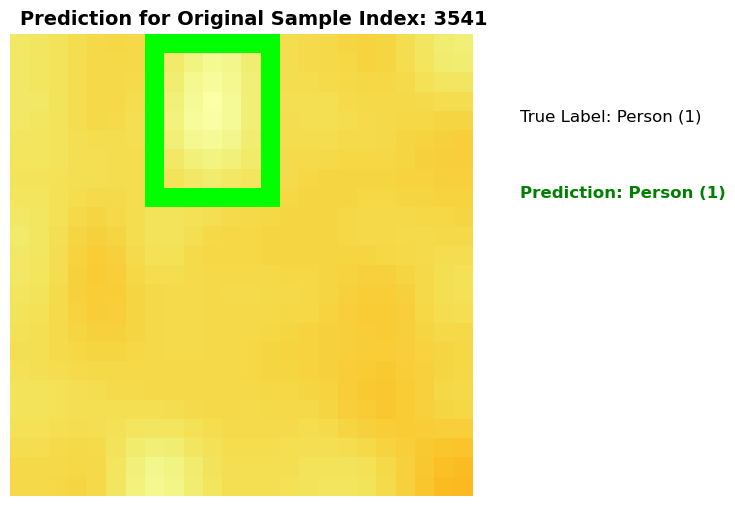


--- Case 2: Correctly Predicted as 'Empty' (True Negative) ---


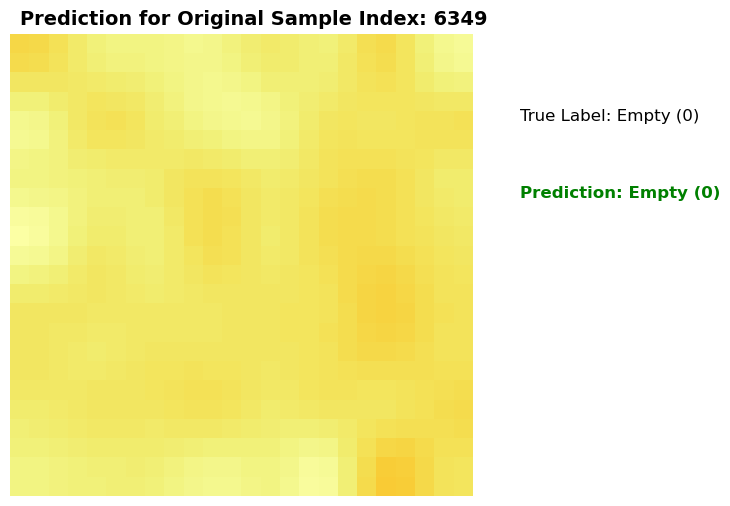


--- Case 3: Incorrectly Predicted as 'Person' (False Positive) ---


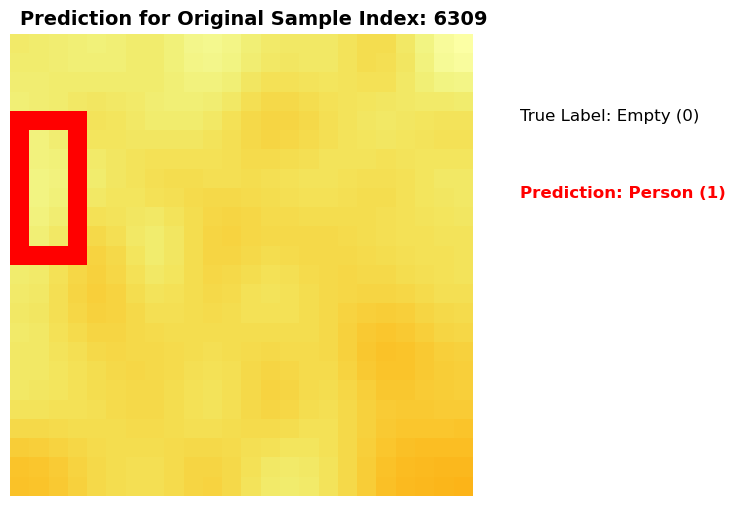


--- Case 4: Incorrectly Predicted as 'Empty' (False Negative) ---


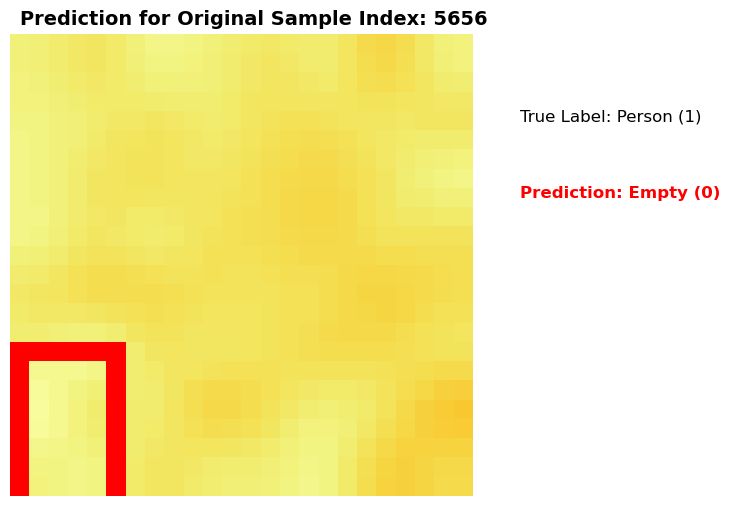

In [32]:
# --- 다양한 케이스의 예측 결과 확인 ---
# 이 부분은 이전과 동일하게 그대로 사용합니다.
tp_indices = np.where((y_test == 1) & (y_pred == 1))[0]
if len(tp_indices) > 0:
    print("\n--- Case 1: Correctly Predicted as 'Person' (True Positive) ---")
    visualize_with_bounding_box_thermo(tp_indices[0], X_test, y_test, y_pred, df, thermal_columns)

tn_indices = np.where((y_test == 0) & (y_pred == 0))[0]
if len(tn_indices) > 0:
    print("\n--- Case 2: Correctly Predicted as 'Empty' (True Negative) ---")
    visualize_with_bounding_box_thermo(tn_indices[0], X_test, y_test, y_pred, df, thermal_columns)
    
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
if len(fp_indices) > 0:
    print("\n--- Case 3: Incorrectly Predicted as 'Person' (False Positive) ---")
    visualize_with_bounding_box_thermo(fp_indices[0], X_test, y_test, y_pred, df, thermal_columns)

fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
if len(fn_indices) > 0:
    print("\n--- Case 4: Incorrectly Predicted as 'Empty' (False Negative) ---")
    visualize_with_bounding_box_thermo(fn_indices[0], X_test, y_test, y_pred, df, thermal_columns)

In [33]:
import joblib

In [34]:
# 모델을 파일로 저장
model_filename = 'lgbm_human_detection_model.joblib'
joblib.dump(lgbm_model, model_filename)

print(f"모델이 {model_filename} 파일로 저장되었습니다.")

모델이 lgbm_human_detection_model.joblib 파일로 저장되었습니다.
